In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import os
import csv
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data_dir = './data'

adata = sc.read(os.path.join(data_dir,'single.filtered.updated.h5ad'))

Only considering the two last: ['.updated', '.h5ad'].
Only considering the two last: ['.updated', '.h5ad'].


In [ ]:
from scipy.stats import ttest_ind

n_components = 40
perturb_gene_list = sorted(list(set(adata.obs['condition'])))
perturb_gene_list.remove('NTC')

ntc_inds = np.where(adata.obs['condition'] == 'NTC')[0]

p_mat = np.zeros((n_components,len(perturb_gene_list)))
sign_mat = np.zeros(p_mat.shape)

for j,perturb_gene in enumerate(perturb_gene_list):
    print(j)
    filtered_adata = adata[(adata.obs['condition'] == 'NTC') | (adata.obs['condition'] == perturb_gene)]
    for i in range(n_components):
        ntc_vals = adata[adata.obs['condition'] == 'NTC'].obsm['X_nmf'][:,i]
        cond_vals = adata[adata.obs['condition'] == perturb_gene].obsm['X_nmf'][:,i]
        
        t,p = ttest_ind(ntc_vals, cond_vals, axis=0, equal_var=False)
        p_mat[i,j] = p
        sign_mat[i,j] = (cond_vals.mean() > ntc_vals.mean()).astype(int)

In [4]:
from statsmodels.stats.multitest import fdrcorrection

q_mat = np.zeros(p_mat.shape)
for j in range(q_mat.shape[1]):
    _,fdr = fdrcorrection(p_mat[:,j])
    q_mat[:,j] = fdr
        
q_mat = -np.log10(q_mat) * (sign_mat-0.5)*2

In [5]:
factors2keep_perturb = np.where((abs(q_mat) > 2).sum(1))[0]
print(np.array(factors2keep_perturb))

conds2keep_perturb = np.where((abs(q_mat) > 2).sum(0))[0]
print(np.array(conds2keep_perturb))

filtered_q_mat = q_mat[factors2keep_perturb][:,conds2keep_perturb]

[ 0  1  2  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 22 23 25 26
 27 28 29 30 31 32 33 34 35 36 37 38 39]
[ 0  1  2  3  4  5  8  9 10 11 13 14 15 16 18 19 20 21 22 23 25 26]


In [6]:
cell_cycle_factors = [6,9,25]

de_factor_inds = [i for i in factors2keep_perturb if i not in cell_cycle_factors]
adata.obsm['X_nmf_de'] = adata.obsm['X_nmf'][:,de_factor_inds]

34


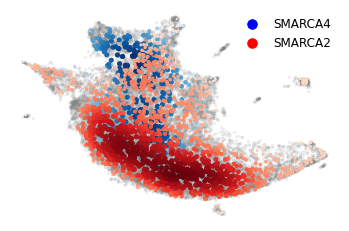

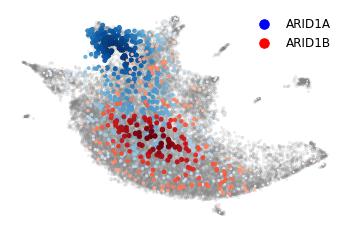

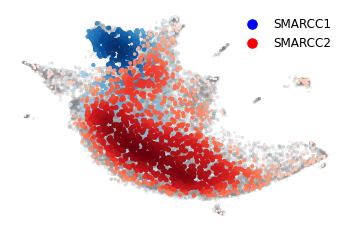

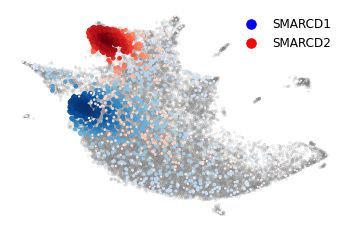

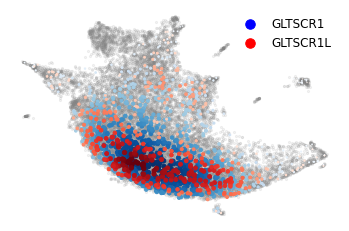

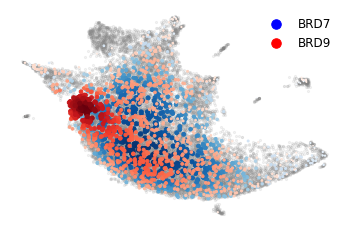

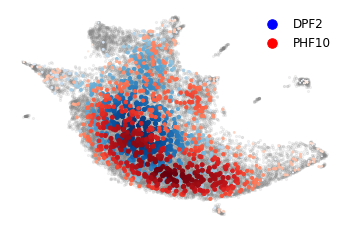

In [7]:
from scipy.stats import gaussian_kde

umap_embeddings = adata.obsm['X_umap']

cat1 = ['SMARCA4','SMARCA2']
cat2 = ['ARID1A','ARID1B']
cat3 = ['SMARCC1','SMARCC2']
cat4 = ['SMARCD1','SMARCD2']
cat5 = ['GLTSCR1','GLTSCR1L']
cat6 = ['BRD7','BRD9']
cat7 = ['DPF2','PHF10']

cat_list = [cat1,cat2,cat3,cat4,cat5,cat6,cat7]


for cat in cat_list:
    cond_list = []
    p1,p2 = cat
    p1_inds = np.where(adata.obs['condition'].values == p1)[0]
    p2_inds = np.where(adata.obs['condition'].values == p2)[0]
    other_inds = [i for i in range(adata.shape[0]) if i not in p1_inds and i not in p2_inds]

    plt.scatter(umap_embeddings[other_inds,0],umap_embeddings[other_inds,1],c='grey',s=5,alpha=0.1)

    xy = np.vstack([umap_embeddings[p1_inds,0],umap_embeddings[p1_inds,1]])
    z = gaussian_kde(xy,bw_method=0.5)(xy)
    min_z = np.min(z)
    max_z = np.max(z)
    z = (z - min_z) / (max_z - min_z)
    
    plt.scatter(umap_embeddings[p1_inds,0],umap_embeddings[p1_inds,1],c=z,s=z*20,label=p1,cmap='Blues')
    
    xy = np.vstack([umap_embeddings[p2_inds,0],umap_embeddings[p2_inds,1]])
    z = gaussian_kde(xy)(xy)
    min_z = np.min(z)
    max_z = np.max(z)
    z = (z - min_z) / (max_z - min_z)
    
    plt.scatter(umap_embeddings[p2_inds,0],umap_embeddings[p2_inds,1],c=z,s=z*20,label=p2,cmap='Reds')

    plt.axis('off')
    plt.tick_params(left=False,bottom=False,labelleft=False,labelbottom=False)
    leg = plt.legend(fontsize=12,bbox_to_anchor=(1,1),markerscale=3,frameon=False)
    leg.legendHandles[0].set_color('blue')
    leg.legendHandles[1].set_color('red')
    plt.show()

## Paralogs
### Paralog Expression vs. Effect

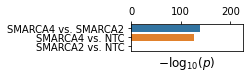

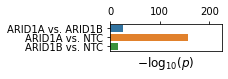

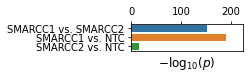

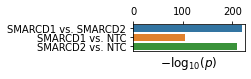

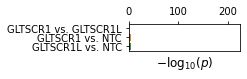

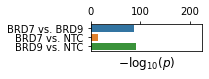

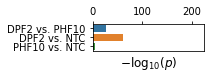

In [29]:
from hotelling.stats import hotelling_t2

cat1 = ['SMARCA4','SMARCA2']
cat2 = ['ARID1A','ARID1B']
cat3 = ['SMARCC1','SMARCC2']
cat4 = ['SMARCD1','SMARCD2']
cat5 = ['GLTSCR1','GLTSCR1L']
cat6 = ['BRD7','BRD9']
cat7 = ['DPF2','PHF10']

cat_list = [cat1,cat2,cat3,cat4,cat5,cat6,cat7]

nmf = adata.obsm['X_nmf_de']

dist_dict = {'paralog_pair': [],'dist': []}

for cat in cat_list:
    p1,p2 = cat
    p1_inds = np.where(adata.obs['condition'].values == p1)[0]
    p2_inds = np.where(adata.obs['condition'].values == p2)[0]
    ntc_inds = np.where(adata.obs['condition'].values == 'NTC')[0]
    
    p1_nmf = nmf[p1_inds]
    p2_nmf = nmf[p2_inds]
    ntc_nmf = nmf[ntc_inds]
    
    _,_,p_p1_p2,_ = hotelling_t2(p1_nmf, p2_nmf)
    _,_,p_p1_ntc,_ = hotelling_t2(p1_nmf, ntc_nmf)
    _,_,p_p2_ntc,_ = hotelling_t2(p2_nmf, ntc_nmf)
    
    data_dict = {'cond': ['{} vs. {}'.format(p1,p2), '{} vs. NTC'.format(p1), '{} vs. NTC'.format(p2)],
                 'p': [p_p1_p2,p_p1_ntc,p_p2_ntc]}
    data_df = pd.DataFrame(data_dict)
    data_df['-log10p'] = -np.log10(data_df['p'])
    
    plt.figure(figsize=(2.,0.5))
    ax = sns.barplot(x='-log10p',y='cond',data=data_df)
    plt.ylabel('')
    plt.xlabel(r'$-\log_{10}(p)$',fontsize=12)
    plt.xticks(fontsize=12)
    plt.xlim([0,225])
    ax.xaxis.tick_top()
    
    plt.show()
    